# Question 2 -  Model to predict the findings of a complaint
#### Mihir Bhaskar
#### 11/23/2021

The following file reads in a cleaned 

In [65]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import wkt
from pyprojroot import here
import datetime as dt

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.metrics import r2_score 
from sklearn.naive_bayes import GaussianNB

from matplotlib import pyplot as plt
import plotly.express as px
import pydot
import graphviz
from graphviz import Source
from sklearn import tree
from IPython.display import Image
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor 
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from dtreeviz.trees import dtreeviz

from sklearn.ensemble import RandomForestClassifier
 

In [66]:
df = pd.read_csv(here('./data/CleanComplaints_FindingLevel.csv'))

df.head()

,CRID,OfficerID,Allegation,Finding,Outcome,Beat,IncidentDate,StartDate,EndDate,InvestigatorRank,...,physical_violence,injury,weapon,on_duty,officer_white,witness_white,officer_male,witness_male,officer_cmp_count,incident_year
0,1073326,18560,Unnecessary Display Of Weapon / Off Duty,No Affidavit,No Action Taken,621.0,2015-01-01,2015-01-12,2015-09-14,NaN,...,0,0,1,0,1,0,1,0,0,2015
1,1073326,24186,Unnecessary Display Of Weapon / Off Duty,No Affidavit,No Action Taken,621.0,2015-01-01,2015-01-12,2015-09-14,NaN,...,0,0,1,0,1,0,1,0,0,2015
2,1073326,18571,Unnecessary Display Of Weapon / Off Duty,No Affidavit,No Action Taken,621.0,2015-01-01,2015-01-12,2015-09-14,NaN,...,0,0,1,0,1,0,1,0,0,2015
3,1073326,32099,Unnecessary Display Of Weapon / Off Duty,No Affidavit,No Action Taken,621.0,2015-01-01,2015-01-12,2015-09-14,NaN,...,0,0,1,0,0,0,1,0,0,2015
4,1073326,14476,Unnecessary Display Of Weapon / Off Duty,No Affidavit,No Action Taken,621.0,2015-01-01,2015-01-12,2015-09-14,NaN,...,0,0,1,0,1,0,1,0,0,2015


In [67]:
# Merging on census tract data stuff
acs = pd.read_csv(here('./data/CleanACSFile.csv'))

df = df.merge(acs, how='left', on=['geo_id'])



In [68]:
df.columns

Index(['CRID', 'OfficerID', 'Allegation', 'Finding', 'Outcome', 'Beat',
       'IncidentDate', 'StartDate', 'EndDate', 'InvestigatorRank',
       ...
       'DP05_0018E', 'DP05_0019PE', 'DP05_0024PE', 'DP05_0037PE',
       'DP05_0038PE', 'DP05_0044PE', 'DP05_0058PE', 'DP05_0071PE', 'geometry',
       'GEOID10'],
      dtype='object', length=111)

## To do:
1. Variable selection/feature exploration
2. Trying out and tuning different types of models/model tuning on sustained/unsustained
3. Changing the target variable I'm classifying on
4. Trying out oversampling methods (if time)
5. Deep-dives into why the model isn't working - is there just not enough variation in the features I felt would be important? For sustained/not-sustained, create some histograms etc.

In [69]:
# Drop columns I'm not using for now
df.drop(columns=['OfficerID', 'Allegation', 'Outcome', 'Beat', 'IncidentDate', 'StartDate', 'EndDate',
                'InvestigatorRank', 'officer_appt_date', 'officer_race', 'officer_gender',
                 'witness_race', 'witness_gender','officer_cmp_count', 'incident_year',
                'geometry', 'GEOID10', 'geo_id'], inplace=True)


# Creating dummy variable columns
df = pd.get_dummies(df, columns=['Finding'])

# Drop the useless dummies
df.drop(columns=['Finding_Exonerated', 'Finding_No Affidavit', 'Finding_Not Sustained', 'Finding_Unfounded', 'Finding_Unknown'], inplace=True)

df.dropna(inplace=True)


y = df['Finding_Sustained']

X = df.drop(columns=['CRID', 'Finding_Sustained'])

X = X.select_dtypes(['number']) 





# Keep only the variables needed in df, and drop observations missing even one of these
#df = df[['CRID', 'Finding_Sustained', 'officer_rank_order', 'officer_age', 'officer_gender_M', 'officer_race_White', 'witness_gender_M', 'witness_race_White']]

#y = df['Finding_Sustained']

# Creating the X variables
#X = df[['officer_rank_order', 'officer_age', 'officer_gender_M', 'officer_race_White', 'witness_gender_M', 'witness_race_White']]


# Balance in the variable
#df[['CRID', 'Finding_Sustained']].groupby('Finding_Sustained').count()

In [70]:
df

,CRID,officer_rank_order,officer_age,physical_violence,injury,weapon,on_duty,officer_white,witness_white,officer_male,...,DP05_0003PE,DP05_0018E,DP05_0019PE,DP05_0024PE,DP05_0037PE,DP05_0038PE,DP05_0044PE,DP05_0058PE,DP05_0071PE,Finding_Sustained
0,1073326,1.0,46.0,0,0,1,0,1,0,1,...,55.5,40.9,24.7,16.2,1.2,97.1,1.7,0.0,0.6,0
1,1073326,1.0,38.0,0,0,1,0,1,0,1,...,55.5,40.9,24.7,16.2,1.2,97.1,1.7,0.0,0.6,0
2,1073326,1.0,39.0,0,0,1,0,1,0,1,...,55.5,40.9,24.7,16.2,1.2,97.1,1.7,0.0,0.6,0
3,1073326,1.0,50.0,0,0,1,0,0,0,1,...,55.5,40.9,24.7,16.2,1.2,97.1,1.7,0.0,0.6,0
4,1073326,2.0,39.0,0,0,1,0,1,0,1,...,55.5,40.9,24.7,16.2,1.2,97.1,1.7,0.0,0.6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1175,1089404,1.0,38.0,0,0,0,0,0,0,1,...,49.4,35.7,18.3,12.2,9.3,87.4,2.6,0.0,0.0,0
1176,1089394,1.0,57.0,0,0,0,1,0,1,1,...,53.4,46.1,21.9,22.2,1.1,96.0,0.0,2.8,0.1,1
1177,1090030,1.0,47.0,0,1,0,1,0,0,1,...,46.5,26.6,34.9,7.7,39.2,9.8,0.0,1.3,88.1,0
1178,1090030,1.0,36.0,0,1,0,1,0,0,1,...,46.5,26.6,34.9,7.7,39.2,9.8,0.0,1.3,88.1,0


              precision    recall  f1-score   support

           0      0.947     0.847     0.894       209
           1      0.059     0.167     0.087        12

    accuracy                          0.810       221
   macro avg      0.503     0.507     0.490       221
weighted avg      0.898     0.810     0.850       221



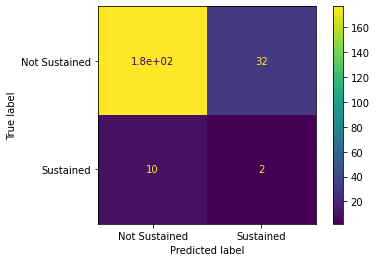

In [71]:
#Creating the classification model (1)

#Creating X and y dataframes

#Splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.20, random_state = 11)                                                      

#Importing class

#Defining model
model = GaussianNB()
nb_pred = model.fit(X_train,y_train).predict(X_test) 
print(classification_report(y_test,nb_pred,digits = 3))

#Confusion matrix
cm = confusion_matrix(y_test,nb_pred) 
target_names = ['Not Sustained','Sustained']
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = target_names)
display_cm.plot()


              precision    recall  f1-score   support

           0      0.948     0.952     0.950       209
           1      0.091     0.083     0.087        12

    accuracy                          0.905       221
   macro avg      0.519     0.518     0.518       221
weighted avg      0.901     0.905     0.903       221



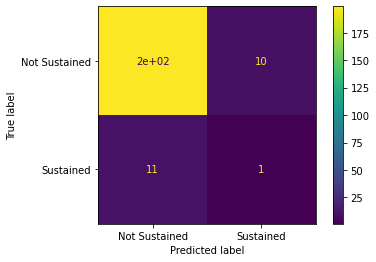

In [72]:
# Random forest classifier
rf = RandomForestClassifier(n_estimators=500, random_state=1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)


print(classification_report(y_test, y_pred, digits = 3))

cm = confusion_matrix(y_test,y_pred) 
target_names = ['Not Sustained','Sustained']
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = target_names)
display_cm.plot()